<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [2]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

In [3]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]"
IPython,7.21.0
MatPlotLib,3.3.4
Numpy,1.20.1
pyAgrum,0.19.3.9


# Credal Net from BN

In [13]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
    bn_min.cpt(n).scale(0.9)
    bn_max.cpt(n).scale(1.1)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.sideBySide(bn.cpt("B"),bn_min.cpt("B"),bn_max.cpt("B"))

#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [14]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeCPTMinMax()

gnb.sideBySide(cn,cn2)

G <!-- B --> B B <!-- C --> C C <!-- B->C --> B->C <!-- D --> D D <!-- D->C --> D->C <!-- F --> F F <!-- A --> A A <!-- A->B --> A->B <!-- A->D --> A->D <!-- E --> E E <!-- A->E --> A->E <!-- E->F --> E->F


Here, $B$ becomes 
- $B-bit-i$ : the $i$-th bit of B
- instrumental $I-B-k$ : the indicator variable for each modality $k$ of $B$

In [15]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

ie_mc.makeInference()
ie2_lbp.makeInference()
ie2_mc.makeInference()

MC in CN


ValueError: Unknown format code '%' for object of type 'str'

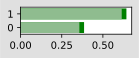

In [24]:
def probaH(pmin,pmax, scale=1.0, txtcolor="black"):
  """
  compute the representation of an horizontal histogram for a mono-dim Potential

  Parameters
  ----------
    pmin,pmax : pyAgrum.Potential
      twao mono-dimensional Potential
    txtcolor : str
      color for text

  Returns
  -------
  matplotlib.Figure
    a matplotlib histogram for a Potential p.
  """
  var = pmin.variable(0)
  ra = np.arange(var.domainSize())

  ra_reverse = np.arange(var.domainSize() - 1, -1, -1)  # reverse order
  vx = ["{0}".format(var.label(int(i))) for i in ra_reverse]

  fig = plt.figure()
  fig.set_figheight(scale * var.domainSize() / 4.0)
  fig.set_figwidth(scale * 2)

  ax = fig.add_subplot(111)
  ax.set_facecolor('white')

  vmin = pmin.tolist()
  vmin.reverse()
  vmax = pmax.tolist()
  vmax.reverse()
  barsmax = ax.barh(ra, vmax,
                 align='center',
                 color="green")
  barsmin = ax.barh(ra, vmin,
                 align='center',
                 color=gum.config['notebook', 'histogram_color'])

  for bar in barsmax:
    if bar.get_width() != 0:
      # ".2%" for instance
      txt_format = "{:." + \
                   str(
                     int(gum.config['notebook', 'horizontal_histogram_visible_digits'])) + "%}"
      txt = txt_format.format(f"{bar.get_width()}")
      ax.text(1, bar.get_y(), txt, ha='right', va='bottom')

  ax.set_xlim(0, 1)
  ax.set_yticks(np.arange(var.domainSize()))
  ax.set_yticklabels(vx, color=txtcolor)
  ax.set_xticklabels([])
  # ax.set_xlabel('Probability')
  # if utility, we do not show the mean/sigma of the proba.
  ax.set_title(pmin.variable(0).name(), color=txtcolor)
  ax.get_xaxis().grid(True)
  ax.margins(0)

  return fig

def showMinMax(cn,ie,var):
        probaH(gum.Potential().add(cn.current_bn().variableFromName(var)).fillWith(ie.marginalMin(var)),
               gum.Potential().add(cn.current_bn().variableFromName(var)).fillWith(ie.marginalMax(var)))
                      

print("MC in CN")
showMinMax(cn,ie_mc,"F")
print("L2U in binarizes CN")
showMinMax(cn2,ie2_lbp,"F")
print("MC in binarized CN")
showMinMax(cn2,ie2_mc,"F")

## Credal Net from bif files

In [7]:
cn=gum.CredalNet(os.path.join("res","cn/2Umin.bif"),os.path.join("res","cn/2Umax.bif"))
cn.intervalToCredal()

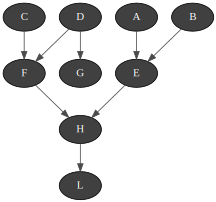

In [8]:
gnb.showBN(cn.current_bn(),"3")

In [9]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile(os.path.join("res","cn/L2U.evi"))

In [10]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [11]:
print(ie.marginalMax(0))
print(ie.marginalMin(0))

(0.6944954927070841, 0.5603434511877096)
(0.4396565488122904, 0.30550450729291595)


# Comparing inference in credal networks

In [12]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)
        c,d=mc.marginalMax(i)
        
        e,f=lbp.marginalMin(i)
        g,h=lbp.marginalMax(i)
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()
cn.computeCPTMinMax()

#### The two inference give quite the same result

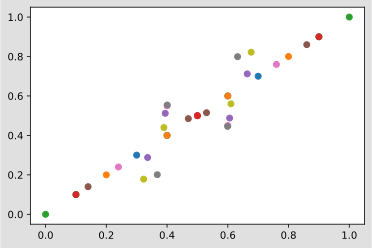

In [13]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

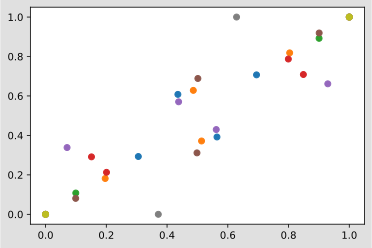

In [14]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [15]:
cn=gum.CredalNet(os.path.join("res","cn/bn_c_8.bif"),os.path.join("res","cn/den_c_8.bif"))
cn.bnToCredal(0.8,False)

In [16]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(True)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()

In [17]:
print(ie.dynamicExpMax("temp"))

(13.796595328051847, 11.630924864746593, 12.02223403338019, 11.923888014816601, 11.953809885616986, 11.943567938674553, 11.947082670196389, 11.94586710688126, 11.946288513782324)


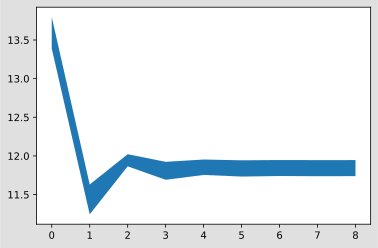

In [18]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [19]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()


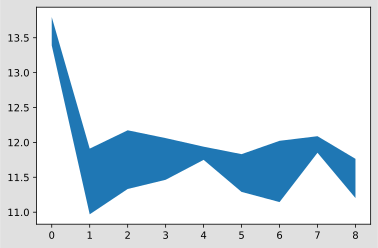

In [20]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

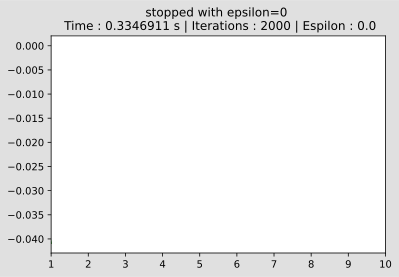

In [21]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(2000)

gnb.animApproximationScheme(ie)
ie.makeInference()

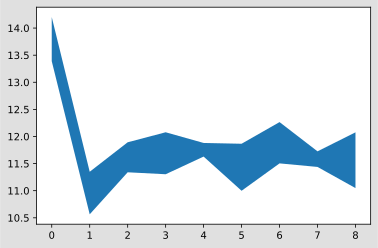

In [22]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));